In [1]:
# from keras.models import Sequential
# from keras.layers import Dense
import tensorflow.compat.v1 as tf
import math
import random
import numpy as np
import pygame
import sys

# Constants
# WIDTH = 1600
# HEIGHT = 880

WIDTH = 1920
HEIGHT = 1080

CAR_SIZE_X = 50    
CAR_SIZE_Y = 50

BORDER_COLOR = (255, 255, 255, 255) # Color To Crash on Hit

current_generation = 0

class Car:

    def __init__(self):
        # Load Car Sprite and Rotate
        self.sprite = pygame.image.load('img\\car.png').convert() # Convert Speeds Up A Lot
        self.sprite = pygame.transform.scale(self.sprite, (CAR_SIZE_X, CAR_SIZE_Y))
        self.rotated_sprite = self.sprite 

        # self.position = [690, 740] # Starting Position
        self.position = [830, 920] # Starting Position
        self.angle = 0
        self.speed = 0

        self.speed_set = False # Flag For Default Speed Later on

        self.center = [self.position[0] + CAR_SIZE_X / 2, self.position[1] + CAR_SIZE_Y / 2] # Calculate Center

        self.radars = [] # List For Sensors / Radars
        self.drawing_radars = [] # Radars To Be Drawn

        self.alive = True # Boolean To Check If Car is Crashed

        self.distance = 0 # Distance Driven
        self.time = 0 # Time Passed

    def draw(self, screen):
        screen.blit(self.rotated_sprite, self.position) # Draw Sprite
        self.draw_radar(screen) #OPTIONAL FOR SENSORS

    def draw_radar(self, screen):
        # Optionally Draw All Sensors / Radars
        for radar in self.radars:
            position = radar[0]
            pygame.draw.line(screen, (0, 255, 0), self.center, position, 1)
            pygame.draw.circle(screen, (0, 255, 0), position, 5)

    def check_collision(self, game_map):
        self.alive = True
        for point in self.corners:
            # If Any Corner Touches Border Color -> Crash
            # Assumes Rectangle
            if game_map.get_at((int(point[0]), int(point[1]))) == BORDER_COLOR:
                self.alive = False
                break

    def check_radar(self, degree, game_map):
        length = 0
        x = int(self.center[0] + math.cos(math.radians(360 - (self.angle + degree))) * length)
        y = int(self.center[1] + math.sin(math.radians(360 - (self.angle + degree))) * length)

        # While We Don't Hit BORDER_COLOR AND length < 300 (just a max) -> go further and further
        while not game_map.get_at((x, y)) == BORDER_COLOR and length < 300:
            length = length + 1
            x = int(self.center[0] + math.cos(math.radians(360 - (self.angle + degree))) * length)
            y = int(self.center[1] + math.sin(math.radians(360 - (self.angle + degree))) * length)

        # Calculate Distance To Border And Append To Radars List
        dist = int(math.sqrt(math.pow(x - self.center[0], 2) + math.pow(y - self.center[1], 2)))
        self.radars.append([(x, y), dist])
    
    def update(self, game_map):
        # Set The Speed To 20 For The First Time
        # Only When Having 4 Output Nodes With Speed Up and Down
        if not self.speed_set:
            self.speed = 20
            self.speed_set = True

        # Get Rotated Sprite And Move Into The Right X-Direction
        # Don't Let The Car Go Closer Than 20px To The Edge
        self.rotated_sprite = self.rotate_center(self.sprite, self.angle)
        self.position[0] += math.cos(math.radians(360 - self.angle)) * self.speed
        self.position[0] = max(self.position[0], 20)
        self.position[0] = min(self.position[0], WIDTH - 120)

        # Increase Distance and Time
        self.distance += self.speed
        self.time += 1
        
        # Same For Y-Position
        self.position[1] += math.sin(math.radians(360 - self.angle)) * self.speed
        self.position[1] = max(self.position[1], 20)
        self.position[1] = min(self.position[1], WIDTH - 120)

        # Calculate New Center
        self.center = [int(self.position[0]) + CAR_SIZE_X / 2, int(self.position[1]) + CAR_SIZE_Y / 2]

        # Calculate Four Corners
        # Length Is Half The Side
        length = 0.5 * CAR_SIZE_X
        left_top = [self.center[0] + math.cos(math.radians(360 - (self.angle + 30))) * length, self.center[1] + math.sin(math.radians(360 - (self.angle + 30))) * length]
        right_top = [self.center[0] + math.cos(math.radians(360 - (self.angle + 150))) * length, self.center[1] + math.sin(math.radians(360 - (self.angle + 150))) * length]
        left_bottom = [self.center[0] + math.cos(math.radians(360 - (self.angle + 210))) * length, self.center[1] + math.sin(math.radians(360 - (self.angle + 210))) * length]
        right_bottom = [self.center[0] + math.cos(math.radians(360 - (self.angle + 330))) * length, self.center[1] + math.sin(math.radians(360 - (self.angle + 330))) * length]
        self.corners = [left_top, right_top, left_bottom, right_bottom]

        # Check Collisions And Clear Radars
        self.check_collision(game_map)
        self.radars.clear()

        # From -90 To 120 With Step-Size 45 Check Radar
        for d in range(-90, 120, 45):
            self.check_radar(d, game_map)

    def get_data(self):
        # Get Distances To Border
        radars = self.radars
        return_values = [0, 0, 0, 0, 0]
        for i, radar in enumerate(radars):
            return_values[i] = int(radar[1] / 30)

        return return_values

    def is_alive(self):
        # Basic Alive Function
        return self.alive

    def get_reward(self):
        # Calculate Reward (Maybe Change?)
        # return self.distance / 50.0
        return self.distance / (CAR_SIZE_X / 2)

    def rotate_center(self, image, angle):
        # Rotate The Rectangle
        rectangle = image.get_rect()
        rotated_image = pygame.transform.rotate(image, angle)
        rotated_rectangle = rectangle.copy()
        rotated_rectangle.center = rotated_image.get_rect().center
        rotated_image = rotated_image.subsurface(rotated_rectangle).copy()
        return rotated_image

pygame 2.3.0 (SDL 2.24.2, Python 3.11.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
class DQCN:
    def __init__(self,epsilon=1, epsilon_decay=0.8, epsilon_min=0.3,batch_size=100, discount_factor=0.9, num_of_episodes=500):
        self.batch_size=batch_size
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.load=False
        self.epsilon_min=epsilon_min
        self.discount_factor=discount_factor
        self.episodes=num_of_episodes
        self.priority=np.array([],dtype='i')
#         self.memory=np.array([],dtype='i')
        self.memory=[]
        self.dict={}
        tf.disable_eager_execution()
        try:
            self.saver=tf.train.import_meta_graph('dqcn_graph.meta')
            self.saver.restore(self.sess, tf.train.latest_checkpoint('./'))
            graph = tf.get_default_graph()
            self.input = graph.get_tensor_by_name("input")
            self.target = graph.get_tensor_by_name("target")
            self.importance=graph.get_tensor_by_name("imp")
            self.load=True
        except:   
            self.input = tf.placeholder(shape=(1,5),dtype=tf.float32,name="input")
            self.target = tf.placeholder(shape=(1,4),dtype=tf.float32,name="target")
            self.importance = tf.placeholder(shape=(None),dtype=tf.float32,name="imp")
        
        self.create_model()
        self.sess=tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def create_model(self):
#         self.model=tf.Sequential()
        #self.model.add(Convolution1D(filters=64, kernel_size=5, activation='relu',input_shape = (5, 1)))
        #self.model.add(Dropout(0.5))
        #self.model.add(MaxPooling1D(pool_size=2))
        #self.model.add(Flatten())
        #self.model.add(Dense(2, activation='relu'))
#         self.model.add(Dense(units=6,activation='sigmoid',input_shape=(5,)))
#         self.model.add(Dense(units=4,activation='relu'))
#         self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        out = tf.layers.dense(inputs=self.input, units=6, activation="relu")
        self.model = tf.layers.dense(inputs=out, units=4 ,activation="linear")
        loss = tf.reduce_mean(tf.multiply(tf.square(self.model - self.target),self.importance))
#         loss=tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.train.AdamOptimizer().minimize(loss)
#         inputs = tf.keras.Input(shape=(5,))
#         outputs = tf.keras.layers.Dense(4, activation=tf.nn.softmax)(inputs)
#         self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
#         self.optimizer = tf.optimizers.Adam()
    
    def prioritize(self, state, next_state, choice, reward, crash, alpha=0.6):
        q_next = reward + self.discount_factor * np.max(self.predict(next_state)[0])
        q = self.predict(state)[0][choice]
        p = (np.abs(q_next-q)+ (np.e ** -10)) ** alpha
        self.priority=np.append(self.priority,np.array(p))
        
#         if tuple(state) in self.dict:
#             if self.dict[tuple(state)][2]<reward:
#                 self.dict[tuple(state)]=[next_state, choice, reward, crash]
#         else:
#             self.map[tuple(state)]=[next_state, choice, reward, crash]
#         self.memory=np.append(self.memory,np.array([[state, next_state, choice, reward, crash]],dtype=object))
        self.memory.append([state, next_state, choice, reward, crash])
    
    def predict(self, input):
        return self.sess.run(self.model, feed_dict={self.input: input})
    
    def fit(self, input, target, importance):
        self.sess.run(self.optimizer, feed_dict={self.input: input, self.target: target, self.importance: importance})

    def batch_priority(self):
        p_sum = np.sum(self.priority)
        prob = self.priority / p_sum
        temp=range(len(prob))
        zipped_pairs = zip(prob, temp)
        z = [x for _, x in sorted(zipped_pairs)]
#         sample_indices = random.choices(range(len(prob)), k=self.batch_size, weights=prob)
        if(len(z)>=self.batch_size):
            sample_indices=z[-self.batch_size:]
        else:
            sample_indices=z
        importance = (1/prob) * (1/len(self.priority))
        importance = np.array(importance)[sample_indices]
        samples = np.array(self.memory)[sample_indices]
        return samples, importance
    
    def replay(self):
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay
        batch, importance = self.batch_priority()
        for b,i in zip(batch,importance):
            state,next_state,result,reward,crash=b
            target=reward
#             if crash:
#                 target = reward + self.discount_factor * np.max(self.predict(next_state)[0])
            final_target = self.predict(state)
            final_target[0][result] = target
            imp = i ** (1-self.epsilon)
            imp = np.reshape(imp, 1)
            self.fit(state, final_target, imp)
            
    def act(self, state):
        if np.random.rand() < self.epsilon:
            temp=random.randrange(0,4,1)
            if(tuple(state[0])) in self.dict and temp in self.dict[tuple(state[0])]:
                return np.argmax(self.predict(state)[0])
            else:
                return temp
        return np.argmax(self.predict(state)[0])
    
    def run(self):
        max_distance=0
        for i in range(self.episodes):
            pygame.init()
            self.screen1 = pygame.display.set_mode((WIDTH, HEIGHT), pygame.FULLSCREEN)
            self.clock = pygame.time.Clock()
            self.generation_font = pygame.font.SysFont("Arial", 30)
            self.alive_font = pygame.font.SysFont("Arial", 20)
            self.game_map = pygame.image.load('img\\map.png').convert()
            car =Car() 
            self.current_generation=1
            counter=0
            state=[car.get_data()]
            while True:
                for event in pygame.event.get():
                    if (event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE)):
                        pygame.quit()
                        return car.distance,max_distance

                # For Each Car Get The Acton It Takes
                #output = nets[i].activate(car.get_data())
#                 output=self.act(state)
                #choice = output.index(max(output))
#                 choice=np.argmax(output[0])
                
#                 if (i==150):
#                     choice=np.argmax(self.predict(state)[0])
#                 else if self.load:
#                     choice=np.argmax(self.predict(state)[0])
#                 else:
                choice=self.act(state)
                if choice == 0:
                    car.angle += 10 # Left
                elif choice == 1:
                    car.angle -= 10 # Right
                elif choice == 2:
                    if(car.speed - 2 >= 12):
                        car.speed -= 2 # Slow Down
                else:
                    car.speed += 2 # Speed Up

                # Check If Car Is Still Alive
                # Increase Fitness If Yes And Break Loop If Not
                still_alive = 0
                if car.is_alive():
                    still_alive += 1
                    #self.train(car.get_data(),output)
                    #self.fit()
                    car.update(self.game_map)
                    max_distance=max(max_distance,car.distance)
                    reward=car.get_reward()
                else:
                    reward=-10
                    temp=tuple(state[0])
                    if temp in self.dict:
                        if choice not in self.dict[temp]:
                            self.dict[temp].append(choice)
                    else:
                        self.dict[temp]=[choice]
                    #genomes[i][1].fitness += car.get_reward()
                
                next_state=[car.get_data()]
                if not self.load:
                    self.prioritize(state, next_state, choice, reward,not car.is_alive())
                state = next_state
#                 print(choice)
                if still_alive == 0:
                    break

                counter += 1
                if counter == 30 * 40: # Stop After About 20 Seconds
                    break

                # Draw Map And All Cars That Are Alive
                self.screen1.blit(self.game_map, (0, 0))
                car.draw(self.screen1)

                # Display Info
                text = self.generation_font.render("Generation: " + str(i), True, (0,0,0))
                text_rect = text.get_rect()
                text_rect.center = (900, 450)
                self.screen1.blit(text, text_rect)

                text = self.alive_font.render("Still Alive: " + str(still_alive), True, (0, 0, 0))
                text_rect = text.get_rect()
                text_rect.center = (900, 490)
                self.screen1.blit(text, text_rect)

                pygame.display.flip()
                self.clock.tick(60) # 60 FPS
#             if(i==150):
#                 return car.distance,max_distance
            if not self.load:
                self.replay()
#         tf.saved_model.save(self.model, 'dqcn_model.h5')
#         self.model.save_weights('dqcn_weights.h5')
#         if not self.load: 
#             saver = tf.train.Saver()
#             saver.save(self.sess,'dqcn_graph')


                    
dqcn = DQCN(num_of_episodes=500)
max_relu,random_relu=dqcn.run()
pygame.quit()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2500\101875799.py:43: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  out = tf.layers.dense(inputs=self.input, units=6, activation="relu")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2500\101875799.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.model = tf.layers.dense(inputs=out, units=4 ,activation="linear")
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2500\101875799.py:86

In [3]:
class DQCN:
    def __init__(self,epsilon=1, epsilon_decay=0.8, epsilon_min=0.3,batch_size=100, discount_factor=0.9, num_of_episodes=500):
        self.batch_size=batch_size
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.load=False
        self.epsilon_min=epsilon_min
        self.discount_factor=discount_factor
        self.episodes=num_of_episodes
        self.priority=np.array([],dtype='i')
        self.memory=[]
        self.dict={}
        tf.disable_eager_execution()
        try:
            self.saver=tf.train.import_meta_graph('dqcn_graph.meta')
            self.saver.restore(self.sess, tf.train.latest_checkpoint('./'))
            graph = tf.get_default_graph()
            self.input = graph.get_tensor_by_name("input")
            self.target = graph.get_tensor_by_name("target")
            self.importance=graph.get_tensor_by_name("imp")
            self.load=True
        except:   
            self.input = tf.placeholder(shape=(1,5),dtype=tf.float32,name="input")
            self.target = tf.placeholder(shape=(1,4),dtype=tf.float32,name="target")
            self.importance = tf.placeholder(shape=(None),dtype=tf.float32,name="imp")
        
        self.create_model()
        self.sess=tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def create_model(self):

        out = tf.layers.dense(inputs=self.input, units=6, activation="sigmoid")
        self.model = tf.layers.dense(inputs=out, units=4 ,activation="linear")
        loss = tf.reduce_mean(tf.multiply(tf.square(self.model - self.target),self.importance))
        self.optimizer = tf.train.AdamOptimizer().minimize(loss)
    def prioritize(self, state, next_state, choice, reward, crash, alpha=0.6):
        q_next = reward + self.discount_factor * np.max(self.predict(next_state)[0])
        q = self.predict(state)[0][choice]
        p = (np.abs(q_next-q)+ (np.e ** -10)) ** alpha
        self.priority=np.append(self.priority,np.array(p))
        
        self.memory.append([state, next_state, choice, reward, crash])
    
    def predict(self, input):
        return self.sess.run(self.model, feed_dict={self.input: input})
    
    def fit(self, input, target, importance):
        self.sess.run(self.optimizer, feed_dict={self.input: input, self.target: target, self.importance: importance})

    def batch_priority(self):
        p_sum = np.sum(self.priority)
        prob = self.priority / p_sum
        sample_indices = random.choices(range(len(prob)), k=self.batch_size, weights=prob)
        importance = (1/prob) * (1/len(self.priority))
        importance = np.array(importance)[sample_indices]
        samples = np.array(self.memory)[sample_indices]
        return samples, importance
    
    def replay(self):
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay
        batch, importance = self.batch_priority()
        for b,i in zip(batch,importance):
            state,next_state,result,reward,crash=b
            target=reward
            final_target = self.predict(state)
            final_target[0][result] = target
            imp = i ** (1-self.epsilon)
            imp = np.reshape(imp, 1)
            self.fit(state, final_target, imp)
            
    def act(self, state):
        if np.random.rand() < self.epsilon:
            temp=random.randrange(0,4,1)
            if(tuple(state[0])) in self.dict and temp in self.dict[tuple(state[0])]:
                return np.argmax(self.predict(state)[0])
            else:
                return temp
        return np.argmax(self.predict(state)[0])
    
    def run(self):
        max_distance=0
        for i in range(self.episodes):
            pygame.init()
            self.screen1 = pygame.display.set_mode((WIDTH, HEIGHT), pygame.FULLSCREEN)
            self.clock = pygame.time.Clock()
            self.generation_font = pygame.font.SysFont("Arial", 30)
            self.alive_font = pygame.font.SysFont("Arial", 20)
            self.game_map = pygame.image.load('img\\map.png').convert()
            car =Car() 
            self.current_generation=1
            counter=0
            state=[car.get_data()]
            while True:
                for event in pygame.event.get():
                    if (event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE)):
                        pygame.quit()
                        return car.distance,max_distance

                if (i==150):
                    choice=np.argmax(self.predict(state)[0])
                else:
                    choice=self.act(state)
                if choice == 0:
                    car.angle += 10 
                elif choice == 1:
                    car.angle -= 10 
                elif choice == 2:
                    if(car.speed - 2 >= 12):
                        car.speed -= 2 
                else:
                    car.speed += 2 

                still_alive = 0
                if car.is_alive():
                    still_alive += 1
                    car.update(self.game_map)
                    max_distance=max(max_distance,car.distance)
                    reward=car.get_reward()
                else:
                    reward=-10
                    temp=tuple(state[0])
                    if temp in self.dict:
                        if choice not in self.dict[temp]:
                            self.dict[temp].append(choice)
                    else:
                        self.dict[temp]=[choice]
                
                next_state=[car.get_data()]
                if not self.load:
                    self.prioritize(state, next_state, choice, reward,not car.is_alive())
                state = next_state
#                 print(choice)
                if still_alive == 0:
                    break

                counter += 1
                if counter == 30 * 40:
                    break

                self.screen1.blit(self.game_map, (0, 0))
                car.draw(self.screen1)

                text = self.generation_font.render("Generation: " + str(i), True, (0,0,0))
                text_rect = text.get_rect()
                text_rect.center = (900, 450)
                self.screen1.blit(text, text_rect)

                text = self.alive_font.render("Still Alive: " + str(still_alive), True, (0, 0, 0))
                text_rect = text.get_rect()
                text_rect.center = (900, 490)
                self.screen1.blit(text, text_rect)

                pygame.display.flip()
                self.clock.tick(60) # 60 FPS
#             if(i==150):
#                 return car.distance,max_distance
            if not self.load:
                self.replay()
#         if not self.load: 
#             saver = tf.train.Saver()
#             saver.save(self.sess,'dqcn_graph')

                    
dqcn = DQCN(num_of_episodes=500)
max_sigmoid,random_sigmoid=dqcn.run()
pygame.quit()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10556\2968154325.py:33: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  out = tf.layers.dense(inputs=self.input, units=6, activation="sigmoid")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10556\2968154325.py:34: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.model = tf.layers.dense(inputs=out, units=4 ,activation="linear")
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10556\2968154

In [4]:
class DQCN:
    def __init__(self,epsilon=1, epsilon_decay=0.8, epsilon_min=0.3,batch_size=100, discount_factor=0.9, num_of_episodes=500):
        self.batch_size=batch_size
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.load=False
        self.epsilon_min=epsilon_min
        self.discount_factor=discount_factor
        self.episodes=num_of_episodes
        self.priority=np.array([],dtype='i')
        self.memory=[]
        self.dict={}
        tf.disable_eager_execution()
        try:
            self.saver=tf.train.import_meta_graph('dqcn_graph.meta')
            self.saver.restore(self.sess, tf.train.latest_checkpoint('./'))
            graph = tf.get_default_graph()
            self.input = graph.get_tensor_by_name("input")
            self.target = graph.get_tensor_by_name("target")
            self.importance=graph.get_tensor_by_name("imp")
            self.load=True
        except:   
            self.input = tf.placeholder(shape=(1,5),dtype=tf.float32,name="input")
            self.target = tf.placeholder(shape=(1,4),dtype=tf.float32,name="target")
            self.importance = tf.placeholder(shape=(None),dtype=tf.float32,name="imp")
        
        self.create_model()
        self.sess=tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def create_model(self):

        out = tf.layers.dense(inputs=self.input, units=6, activation="tanh")
        self.model = tf.layers.dense(inputs=out, units=4 ,activation="linear")
        loss = tf.reduce_mean(tf.multiply(tf.square(self.model - self.target),self.importance))
        self.optimizer = tf.train.AdamOptimizer().minimize(loss)
    def prioritize(self, state, next_state, choice, reward, crash, alpha=0.6):
        q_next = reward + self.discount_factor * np.max(self.predict(next_state)[0])
        q = self.predict(state)[0][choice]
        p = (np.abs(q_next-q)+ (np.e ** -10)) ** alpha
        self.priority=np.append(self.priority,np.array(p))
        
        self.memory.append([state, next_state, choice, reward, crash])
    
    def predict(self, input):
        return self.sess.run(self.model, feed_dict={self.input: input})
    
    def fit(self, input, target, importance):
        self.sess.run(self.optimizer, feed_dict={self.input: input, self.target: target, self.importance: importance})

    def batch_priority(self):
        p_sum = np.sum(self.priority)
        prob = self.priority / p_sum
        sample_indices = random.choices(range(len(prob)), k=self.batch_size, weights=prob)
        importance = (1/prob) * (1/len(self.priority))
        importance = np.array(importance)[sample_indices]
        samples = np.array(self.memory)[sample_indices]
        return samples, importance
    
    def replay(self):
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay
        batch, importance = self.batch_priority()
        for b,i in zip(batch,importance):
            state,next_state,result,reward,crash=b
            target=reward
            final_target = self.predict(state)
            final_target[0][result] = target
            imp = i ** (1-self.epsilon)
            imp = np.reshape(imp, 1)
            self.fit(state, final_target, imp)
            
    def act(self, state):
        if np.random.rand() < self.epsilon:
            temp=random.randrange(0,4,1)
            if(tuple(state[0])) in self.dict and temp in self.dict[tuple(state[0])]:
                return np.argmax(self.predict(state)[0])
            else:
                return temp
        return np.argmax(self.predict(state)[0])
    
    def run(self):
        max_distance=0
        for i in range(self.episodes):
            pygame.init()
            self.screen1 = pygame.display.set_mode((WIDTH, HEIGHT), pygame.FULLSCREEN)
            self.clock = pygame.time.Clock()
            self.generation_font = pygame.font.SysFont("Arial", 30)
            self.alive_font = pygame.font.SysFont("Arial", 20)
            self.game_map = pygame.image.load('img\\map.png').convert()
            car =Car() 
            self.current_generation=1
            counter=0
            state=[car.get_data()]
            while True:
                for event in pygame.event.get():
                    if (event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE)):
                        pygame.quit()
                        return car.distance,max_distance
                        
                if (i==150):
                    choice=np.argmax(self.predict(state)[0])
                else:
                    choice=self.act(state)
                if choice == 0:
                    car.angle += 10 
                elif choice == 1:
                    car.angle -= 10 
                elif choice == 2:
                    if(car.speed - 2 >= 12):
                        car.speed -= 2 
                else:
                    car.speed += 2 

                still_alive = 0
                if car.is_alive():
                    still_alive += 1
                    car.update(self.game_map)
                    max_distance=max(max_distance,car.distance)
                    reward=car.get_reward()
                else:
                    reward=-10
                    temp=tuple(state[0])
                    if temp in self.dict:
                        if choice not in self.dict[temp]:
                            self.dict[temp].append(choice)
                    else:
                        self.dict[temp]=[choice]
                
                next_state=[car.get_data()]
                if not self.load:
                    self.prioritize(state, next_state, choice, reward,not car.is_alive())
                state = next_state
#                 print(choice)
                if still_alive == 0:
                    break

                counter += 1
                if counter == 30 * 40:
                    break

                self.screen1.blit(self.game_map, (0, 0))
                car.draw(self.screen1)

                text = self.generation_font.render("Generation: " + str(i), True, (0,0,0))
                text_rect = text.get_rect()
                text_rect.center = (900, 450)
                self.screen1.blit(text, text_rect)

                text = self.alive_font.render("Still Alive: " + str(still_alive), True, (0, 0, 0))
                text_rect = text.get_rect()
                text_rect.center = (900, 490)
                self.screen1.blit(text, text_rect)

                pygame.display.flip()
                self.clock.tick(60) # 60 FPS
            if(i==150):
                return car.distance,max_distance
            if not self.load:
                self.replay()
#         if not self.load: 
#             saver = tf.train.Saver()
#             saver.save(self.sess,'dqcn_graph')

                    
dqcn = DQCN(num_of_episodes=500)
max_tanh,random_tanh=dqcn.run()
pygame.quit()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10556\57397118.py:33: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  out = tf.layers.dense(inputs=self.input, units=6, activation="tanh")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10556\57397118.py:34: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.model = tf.layers.dense(inputs=out, units=4 ,activation="linear")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10556\57397118.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(self.memory)[sample_indices]


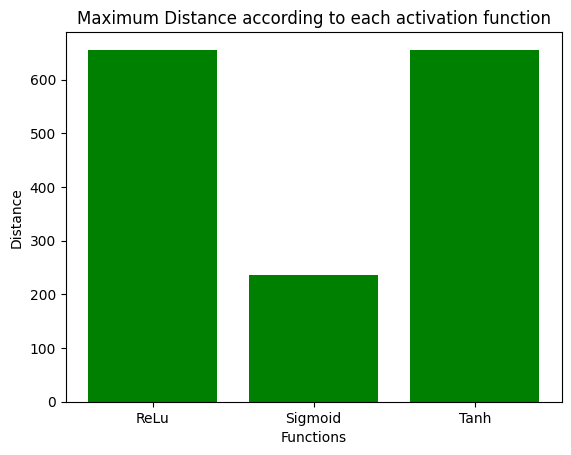

In [8]:
import matplotlib.pyplot as plt
functions=['ReLu','Sigmoid','Tanh']
distance=[max_relu,max_sigmoid,max_tanh]
plt.bar(functions,distance,color='green')
plt.xlabel('Functions')
plt.ylabel('Distance')
plt.title('Maximum Distance according to each activation function')
plt.show()

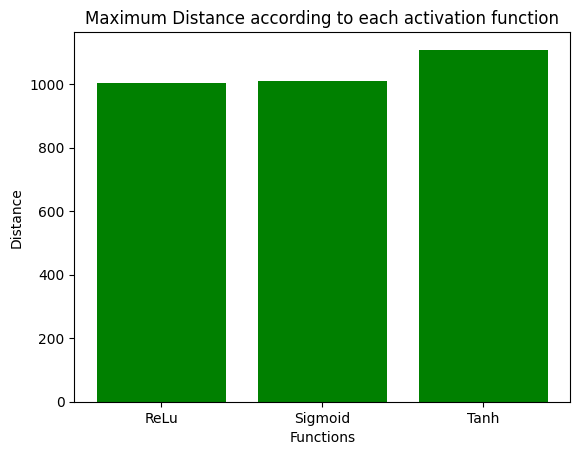

In [9]:
functions=['ReLu','Sigmoid','Tanh']
distance=[random_relu,random_sigmoid,random_tanh]
plt.bar(functions,distance,color='green')
plt.xlabel('Functions')
plt.ylabel('Distance')
plt.title('Maximum Distance according to each activation function')
plt.show()

In [5]:
class DQCN:
    def __init__(self,epsilon=1, epsilon_decay=0.8, epsilon_min=0.3,batch_size=100, discount_factor=0.9, num_of_episodes=500):
        self.batch_size=batch_size
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.load=False
        self.epsilon_min=epsilon_min
        self.discount_factor=discount_factor
        self.episodes=num_of_episodes
        self.priority=np.array([],dtype='i')
#         self.memory=np.array([],dtype='i')
        self.memory=[]
        self.dict={}
        tf.disable_eager_execution()
        try:
            self.saver=tf.train.import_meta_graph('dqcn_graph.meta')
            self.saver.restore(self.sess, tf.train.latest_checkpoint('./'))
            graph = tf.get_default_graph()
            self.input = graph.get_tensor_by_name("input")
            self.target = graph.get_tensor_by_name("target")
            self.importance=graph.get_tensor_by_name("imp")
            self.load=True
        except:   
            self.input = tf.placeholder(shape=(1,5),dtype=tf.float32,name="input")
            self.target = tf.placeholder(shape=(1,4),dtype=tf.float32,name="target")
            self.importance = tf.placeholder(shape=(None),dtype=tf.float32,name="imp")
        
        self.create_model()
        self.sess=tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def create_model(self):
#         self.model=tf.Sequential()
        #self.model.add(Convolution1D(filters=64, kernel_size=5, activation='relu',input_shape = (5, 1)))
        #self.model.add(Dropout(0.5))
        #self.model.add(MaxPooling1D(pool_size=2))
        #self.model.add(Flatten())
        #self.model.add(Dense(2, activation='relu'))
#         self.model.add(Dense(units=6,activation='sigmoid',input_shape=(5,)))
#         self.model.add(Dense(units=4,activation='relu'))
#         self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        out = tf.layers.dense(inputs=self.input, units=6, activation="relu")
        self.model = tf.layers.dense(inputs=out, units=4 ,activation="linear")
        loss = tf.reduce_mean(tf.multiply(tf.square(self.model - self.target),self.importance))
#         loss=tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
#         inputs = tf.keras.Input(shape=(5,))
#         outputs = tf.keras.layers.Dense(4, activation=tf.nn.softmax)(inputs)
#         self.model = tf.keras.Model(inputs=inputs, outputs=outputs)
#         self.optimizer = tf.optimizers.Adam()
    
    def prioritize(self, state, next_state, choice, reward, crash, alpha=0.6):
        q_next = reward + self.discount_factor * np.max(self.predict(next_state)[0])
        q = self.predict(state)[0][choice]
        p = (np.abs(q_next-q)+ (np.e ** -10)) ** alpha
        self.priority=np.append(self.priority,np.array(p))
        
#         if tuple(state) in self.dict:
#             if self.dict[tuple(state)][2]<reward:
#                 self.dict[tuple(state)]=[next_state, choice, reward, crash]
#         else:
#             self.map[tuple(state)]=[next_state, choice, reward, crash]
#         self.memory=np.append(self.memory,np.array([[state, next_state, choice, reward, crash]],dtype=object))
        self.memory.append([state, next_state, choice, reward, crash])
    
    def predict(self, input):
        return self.sess.run(self.model, feed_dict={self.input: input})
    
    def fit(self, input, target, importance):
        self.sess.run(self.optimizer, feed_dict={self.input: input, self.target: target, self.importance: importance})

    def batch_priority(self):
        p_sum = np.sum(self.priority)
        prob = self.priority / p_sum
        temp=range(len(prob))
        zipped_pairs = zip(prob, temp)
        z = [x for _, x in sorted(zipped_pairs)]
#         sample_indices = random.choices(range(len(prob)), k=self.batch_size, weights=prob)
        if(len(z)>=self.batch_size):
            sample_indices=z[-self.batch_size:]
        else:
            sample_indices=z
        importance = (1/prob) * (1/len(self.priority))
        importance = np.array(importance)[sample_indices]
        samples = np.array(self.memory)[sample_indices]
        return samples, importance
    
    def replay(self):
        if self.epsilon>self.epsilon_min:
            self.epsilon*=self.epsilon_decay
        batch, importance = self.batch_priority()
        for b,i in zip(batch,importance):
            state,next_state,result,reward,crash=b
            target=reward
#             if crash:
#                 target = reward + self.discount_factor * np.max(self.predict(next_state)[0])
            final_target = self.predict(state)
            final_target[0][result] = target
            imp = i ** (1-self.epsilon)
            imp = np.reshape(imp, 1)
            self.fit(state, final_target, imp)
            
    def act(self, state):
        if np.random.rand() < self.epsilon:
            temp=random.randrange(0,4,1)
            if(tuple(state[0])) in self.dict and temp in self.dict[tuple(state[0])]:
                return np.argmax(self.predict(state)[0])
            else:
                return temp
        return np.argmax(self.predict(state)[0])
    
    def run(self):
        max_distance=0
        for i in range(self.episodes):
            pygame.init()
            self.screen1 = pygame.display.set_mode((WIDTH, HEIGHT), pygame.FULLSCREEN)
            self.clock = pygame.time.Clock()
            self.generation_font = pygame.font.SysFont("Arial", 30)
            self.alive_font = pygame.font.SysFont("Arial", 20)
            self.game_map = pygame.image.load('img\\map.png').convert()
            car =Car() 
            self.current_generation=1
            counter=0
            state=[car.get_data()]
            while True:
                for event in pygame.event.get():
                    if (event.type == pygame.QUIT or (event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE)):
                        pygame.quit()
                        return car.distance,max_distance

                # For Each Car Get The Acton It Takes
                #output = nets[i].activate(car.get_data())
#                 output=self.act(state)
                #choice = output.index(max(output))
#                 choice=np.argmax(output[0])
                
                if (i==150):
                    choice=np.argmax(self.predict(state)[0])
#                 else if self.load:
#                     choice=np.argmax(self.predict(state)[0])
                else:
                    choice=self.act(state)
                if choice == 0:
                    car.angle += 10 # Left
                elif choice == 1:
                    car.angle -= 10 # Right
                elif choice == 2:
                    if(car.speed - 2 >= 12):
                        car.speed -= 2 # Slow Down
                else:
                    car.speed += 2 # Speed Up

                # Check If Car Is Still Alive
                # Increase Fitness If Yes And Break Loop If Not
                still_alive = 0
                if car.is_alive():
                    still_alive += 1
                    #self.train(car.get_data(),output)
                    #self.fit()
                    car.update(self.game_map)
                    max_distance=max(max_distance,car.distance)
                    reward=car.get_reward()
                else:
                    reward=-10
                    temp=tuple(state[0])
                    if temp in self.dict:
                        if choice not in self.dict[temp]:
                            self.dict[temp].append(choice)
                    else:
                        self.dict[temp]=[choice]
                    #genomes[i][1].fitness += car.get_reward()
                
                next_state=[car.get_data()]
                if not self.load:
                    self.prioritize(state, next_state, choice, reward,not car.is_alive())
                state = next_state
#                 print(choice)
                if still_alive == 0:
                    break

                counter += 1
                if counter == 30 * 40: # Stop After About 20 Seconds
                    break

                # Draw Map And All Cars That Are Alive
                self.screen1.blit(self.game_map, (0, 0))
                car.draw(self.screen1)

                # Display Info
                text = self.generation_font.render("Generation: " + str(i), True, (0,0,0))
                text_rect = text.get_rect()
                text_rect.center = (900, 450)
                self.screen1.blit(text, text_rect)

                text = self.alive_font.render("Still Alive: " + str(still_alive), True, (0, 0, 0))
                text_rect = text.get_rect()
                text_rect.center = (900, 490)
                self.screen1.blit(text, text_rect)

                pygame.display.flip()
                self.clock.tick(60) # 60 FPS
            if(i==150):
                return car.distance,max_distance
            if not self.load:
                self.replay()
#         tf.saved_model.save(self.model, 'dqcn_model.h5')
#         self.model.save_weights('dqcn_weights.h5')
#         if not self.load: 
#             saver = tf.train.Saver()
#             saver.save(self.sess,'dqcn_graph')


                    
dqcn = DQCN(num_of_episodes=500)
max_gdo,random_gdo=dqcn.run()
pygame.quit()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3380\1901178696.py:43: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  out = tf.layers.dense(inputs=self.input, units=6, activation="relu")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3380\1901178696.py:44: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.model = tf.layers.dense(inputs=out, units=4 ,activation="linear")
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3380\1901178696.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.array(self.memory)[sample_indices]


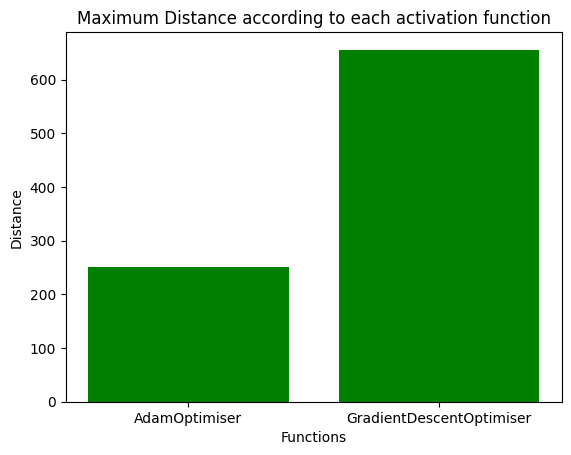

In [6]:
import matplotlib.pyplot as plt
functions=['AdamOptimiser','GradientDescentOptimiser']
distance=[max_relu,max_gdo]
plt.bar(functions,distance,color='green')
plt.xlabel('Functions')
plt.ylabel('Distance')
plt.title('Maximum Distance according to each activation function')
plt.show()